# Fine-tuning DTrOCR on IAM dataset
This is an example of fine-tuning DTrOCR on IAM dataset handwritten words from [Kaggle](https://www.kaggle.com/datasets/teykaicong/iamondb-handwriting-dataset). IAM Aachen splits can be downloaded [here](https://www.openslr.org/56/).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset folder structure
```
iam_words/
│
├── words/                              # Folder containing word images as PNGs
│   ├── a01/                            # First folder
│   │   ├── a01-000u/
│   │   │   ├── a01-000u-00-00.png
│   │   │   └── a01-000u-00-01.png
│   │   .
│   │   .
│   │   .
│   └── r06/                            # Last folder
│       ├── r06-000/
│       │   ├── r06-000-00-00.png
│       │   └── r06-000-00-01.png
│
├── xml/                                # XML files
│	├── a01-000u.xml
│	.
│	.
│	.
│	└── r06-143.xml
│
└── splits/                             # IAM Aachen splits
    ├── train.uttlist
    ├── validation.uttlist
    └── test.uttlist
```

In [2]:
!unzip /content/drive/MyDrive/Colab_Notebooks/DTrOCR.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-03-02.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-03-03.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-03-04.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-03-05.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-03-06.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-03-07.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-03-08.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-03-09.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-04-00.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-04-01.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-04-02.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-04-03.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-04-04.png  
  inflating: DTrOCR/dataset/words/r02/r02-131/r02-131-04-05.png  
  inflating: DTrOCR

# Build lists of images and texts

In [3]:
%cd /content/DTrOCR

/content/DTrOCR


In [4]:
import glob
from pathlib import Path

dataset_path = Path('/content/DTrOCR/dataset')

xml_files = sorted(glob.glob(str(dataset_path / 'xml' / '*.xml')))
word_image_files = sorted(glob.glob(str(dataset_path / 'words' / '**' / '*.png'), recursive=True))

print(f"{len(xml_files)} XML files and {len(word_image_files)} word image files")

1539 XML files and 115320 word image files


In [5]:
import tqdm
import multiprocessing as mp
import xml.etree.ElementTree as ET

from PIL import Image
from dataclasses import dataclass


@dataclass
class Word:
    id: str
    file_path: Path
    writer_id: str
    transcription: str

def get_words_from_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    root_id = root.get('id')
    writer_id = root.get('writer-id')
    xml_words = []
    for line in root.findall('handwritten-part')[0].findall('line'):
        for word in line.findall('word'):
            image_file = Path([f for f in word_image_files if f.endswith(word.get('id') + '.png')][0])
            try:
                with Image.open(image_file) as _:
                    xml_words.append(
                        Word(
                            id=root_id,
                            file_path=image_file,
                            writer_id=writer_id,
                            transcription=word.get('text')
                        )
                    )
            except Exception:
                pass

    return xml_words

with mp.Pool(processes=mp.cpu_count()) as pool:
    words_from_xmls = list(
        tqdm.tqdm(
            pool.imap(get_words_from_xml, xml_files),
            total=len(xml_files),
            desc='Building dataset'
        )
    )

words = [word for words in words_from_xmls for word in words]

Building dataset: 100%|██████████| 1539/1539 [07:31<00:00,  3.41it/s]


# Train test split

In [6]:
with open('/content/DTrOCR/dataset/splits/train.uttlist') as fp:
    train_ids = [line.replace('\n', '') for line in fp.readlines()]

with open('/content/DTrOCR/dataset/splits/test.uttlist') as fp:
    test_ids = [line.replace('\n', '') for line in fp.readlines()]

with open('/content/DTrOCR/dataset/splits/validation.uttlist') as fp:
    validation_ids = [line.replace('\n', '') for line in fp.readlines()]

print(f"Train size: {len(train_ids)}; Validation size: {len(validation_ids)}; Test size: {len(test_ids)}")

Train size: 747; Validation size: 116; Test size: 336


In [7]:
train_word_records = [word for word in words if word.id in train_ids]
validation_word_records = [word for word in words if word.id in validation_ids]
test_word_records = [word for word in words if word.id in test_ids]

print(f'Train size: {len(train_word_records)}; Validation size: {len(validation_word_records)}; Test size: {len(test_word_records)}')

Train size: 55079; Validation size: 8895; Test size: 25920


# Build dataset and dataloader

In [8]:
from dtrocr.processor import DTrOCRProcessor
from dtrocr.config import DTrOCRConfig

from torch.utils.data import Dataset

class IAMDataset(Dataset):
    def __init__(self, words: list[Word], config: DTrOCRConfig):
        super(IAMDataset, self).__init__()
        self.words = words
        self.processor = DTrOCRProcessor(config, add_eos_token=True, add_bos_token=True)

    def __len__(self):
        return len(self.words)

    def __getitem__(self, item):
        inputs = self.processor(
            images=Image.open(self.words[item].file_path).convert('RGB'),
            texts=self.words[item].transcription,
            padding='max_length',
            return_tensors="pt",
            return_labels=True,
        )
        return {
            'pixel_values': inputs.pixel_values[0],
            'input_ids': inputs.input_ids[0],
            'attention_mask': inputs.attention_mask[0],
            'labels': inputs.labels[0]
        }

config = DTrOCRConfig(
    # attn_implementation='flash_attention_2'
)

train_data = IAMDataset(words=train_word_records, config=config)
validation_data = IAMDataset(words=validation_word_records, config=config)
test_data = IAMDataset(words=test_word_records, config=config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=mp.cpu_count())
validation_dataloader = DataLoader(validation_data, batch_size=32, shuffle=False, num_workers=mp.cpu_count())
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=mp.cpu_count())

# Model

In [10]:
import torch
torch.set_float32_matmul_precision('high')

from dtrocr.model import DTrOCRLMHeadModel

model = DTrOCRLMHeadModel(config)
model = torch.compile(model)
model.to(device=0)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

OptimizedModule(
  (_orig_mod): DTrOCRLMHeadModel(
    (transformer): DTrOCRModel(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(4, 8), stride=(4, 8))
      )
      (token_embedding): Embedding(50257, 768)
      (positional_embedding): Embedding(256, 768)
      (hidden_layers): ModuleList(
        (0-11): 12 x GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D(nf=2304, nx=768)
            (c_proj): Conv1D(nf=768, nx=768)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=3072, nx=768)
            (c_proj): Conv1D(nf=768, nx=3072)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )


# Training

In [11]:
from typing import Tuple

def evaluate_model(model: torch.nn.Module, dataloader: DataLoader) -> Tuple[float, float]:
    # set model to evaluation mode
    model.eval()

    losses, accuracies = [], []
    with torch.no_grad():
        for inputs in tqdm.tqdm(dataloader, total=len(dataloader), desc=f'Evaluating test set'):
            inputs = send_inputs_to_device(inputs, device=0)
            outputs = model(**inputs)

            losses.append(outputs.loss.item())
            accuracies.append(outputs.accuracy.item())

    loss = sum(losses) / len(losses)
    accuracy = sum(accuracies) / len(accuracies)

    # set model back to training mode
    model.train()

    return loss, accuracy

def send_inputs_to_device(dictionary, device):
    return {key: value.to(device=device) if isinstance(value, torch.Tensor) else value for key, value in dictionary.items()}

use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
optimiser = torch.optim.Adam(params=model.parameters(), lr=1e-4)

EPOCHS = 12
train_losses, train_accuracies = [], []
validation_losses, validation_accuracies = [], []
for epoch in range(EPOCHS):
    epoch_losses, epoch_accuracies = [], []
    for inputs in tqdm.tqdm(train_dataloader, total=len(train_dataloader), desc=f'Epoch {epoch + 1}'):

        # set gradients to zero
        optimiser.zero_grad()

        # send inputs to same device as model
        inputs = send_inputs_to_device(inputs, device=0)

        # forward pass
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=use_amp):
            outputs = model(**inputs)

        # calculate gradients
        scaler.scale(outputs.loss).backward()

        # update weights
        scaler.step(optimiser)
        scaler.update()

        epoch_losses.append(outputs.loss.item())
        epoch_accuracies.append(outputs.accuracy.item())

    # store loss and metrics
    train_losses.append(sum(epoch_losses) / len(epoch_losses))
    train_accuracies.append(sum(epoch_accuracies) / len(epoch_accuracies))

    # tests loss and accuracy
    validation_loss, validation_accuracy = evaluate_model(model, validation_dataloader)
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"Epoch: {epoch + 1} - Train loss: {train_losses[-1]}, Train accuracy: {train_accuracies[-1]}, Validation loss: {validation_losses[-1]}, Validation accuracy: {validation_accuracies[-1]}")

<ipython-input-11-b9945695f831>:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
Evaluating test set: 100%|██████████| 278/278 [01:08<00:00,  4.07it/s]


Epoch: 1 - Train loss: 3.732712994330713, Train accuracy: 0.5164852411947002, Validation loss: 3.0629228679396268, Validation accuracy: 0.5793072825713124


Evaluating test set: 100%|██████████| 278/278 [00:39<00:00,  7.03it/s]


Epoch: 2 - Train loss: 2.6048872486777976, Train accuracy: 0.593763573486769, Validation loss: 2.718600634190676, Validation accuracy: 0.6170445003097863


Evaluating test set: 100%|██████████| 278/278 [00:39<00:00,  7.03it/s]


Epoch: 3 - Train loss: 2.1103882492627, Train accuracy: 0.6421899763168497, Validation loss: 2.5336005190293567, Validation accuracy: 0.6424546158142227


Evaluating test set: 100%|██████████| 278/278 [00:39<00:00,  7.03it/s]


Epoch: 4 - Train loss: 1.7301461363295645, Train accuracy: 0.6867147041841667, Validation loss: 2.3765711655719675, Validation accuracy: 0.6590538395823334


Evaluating test set: 100%|██████████| 278/278 [00:39<00:00,  7.03it/s]


Epoch: 5 - Train loss: 1.403539088579559, Train accuracy: 0.7303342118980439, Validation loss: 2.3195932689759373, Validation accuracy: 0.6737558181337315


Evaluating test set: 100%|██████████| 278/278 [00:39<00:00,  7.03it/s]


Epoch: 6 - Train loss: 1.127810170772322, Train accuracy: 0.7719936113670451, Validation loss: 2.3000257943602773, Validation accuracy: 0.6774836146145415


Evaluating test set: 100%|██████████| 278/278 [00:39<00:00,  7.03it/s]


Epoch: 7 - Train loss: 0.878967253882849, Train accuracy: 0.8150750031039274, Validation loss: 2.2328241004360665, Validation accuracy: 0.6910668077657549


Evaluating test set: 100%|██████████| 278/278 [00:39<00:00,  7.03it/s]


Epoch: 8 - Train loss: 0.657652373530585, Train accuracy: 0.8581577593787345, Validation loss: 2.246124173668649, Validation accuracy: 0.6922021937027252


Evaluating test set: 100%|██████████| 278/278 [00:39<00:00,  7.03it/s]


Epoch: 9 - Train loss: 0.4656375775440368, Train accuracy: 0.9008422931450724, Validation loss: 2.296828444055516, Validation accuracy: 0.6953648107943775


Evaluating test set: 100%|██████████| 278/278 [00:39<00:00,  7.03it/s]


Epoch: 10 - Train loss: 0.31118049927739455, Train accuracy: 0.9369018426063307, Validation loss: 2.308905752013913, Validation accuracy: 0.6941280810953044


Evaluating test set: 100%|██████████| 278/278 [00:39<00:00,  7.02it/s]


Epoch: 11 - Train loss: 0.2037107658082496, Train accuracy: 0.9607342250394212, Validation loss: 2.3719807929701084, Validation accuracy: 0.70100429761324


Evaluating test set: 100%|██████████| 278/278 [00:39<00:00,  7.03it/s]

Epoch: 12 - Train loss: 0.13423158242675484, Train accuracy: 0.9751001341348464, Validation loss: 2.4354026690661477, Validation accuracy: 0.7027099237596388


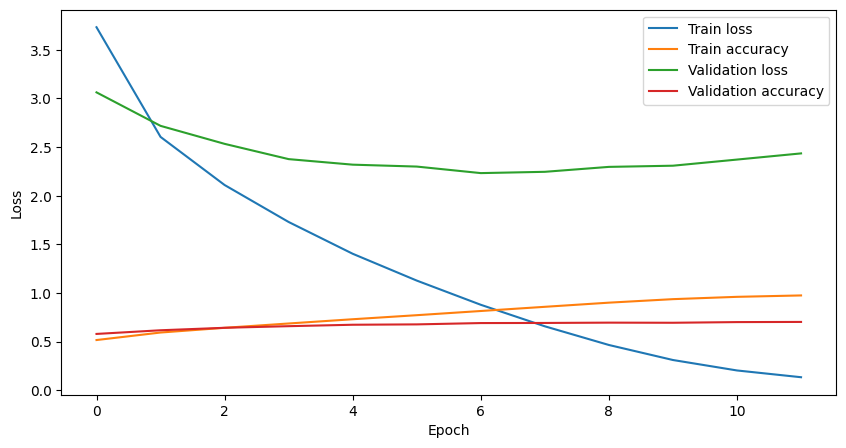

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train loss')
plt.plot(train_accuracies, label='Train accuracy')
plt.plot(validation_losses, label='Validation loss')
plt.plot(validation_accuracies, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# # prompt: viết mã code để real time sử dụng cv2

# import cv2
# import time

# # Initialize camera
# cap = cv2.VideoCapture(0)  # 0 for default camera

# if not cap.isOpened():
#     print("Cannot open camera")
#     exit()

# # Process frames in real-time
# while True:
#     ret, frame = cap.read()

#     if not ret:
#         print("Can't receive frame (stream end?). Exiting ...")
#         break

#     # Perform your desired operations on the frame here.
#     # Example: Display the frame.
#     cv2.imshow('Real-time Video', frame)

#     # Break the loop if 'q' is pressed.
#     if cv2.waitKey(1) == ord('q'):
#         break

# # Release resources
# cap.release()
# cv2.destroyAllWindows()


# Test

In [17]:
torch.save(model, '/content/drive/MyDrive/Colab_Notebooks/model.pth')

In [15]:
from dtrocr.model import DTrOCRLMHeadModel
from dtrocr.config import DTrOCRConfig
from dtrocr.processor import DTrOCRProcessor

# model = DTrOCRLMHeadModel(DTrOCRConfig())
model.eval()
model.to('cpu')
test_processor = DTrOCRProcessor(DTrOCRConfig())

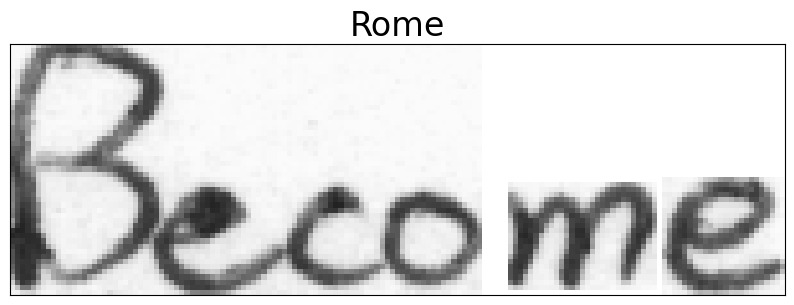

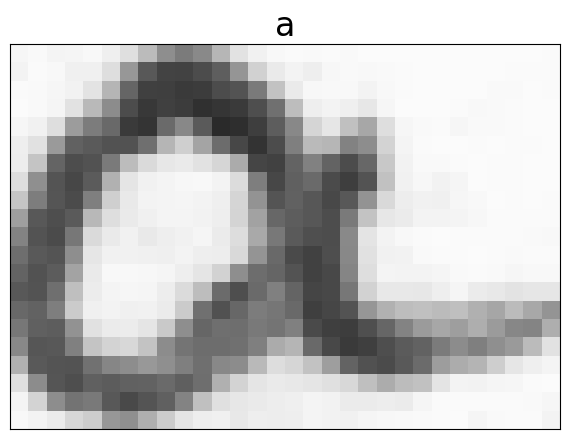

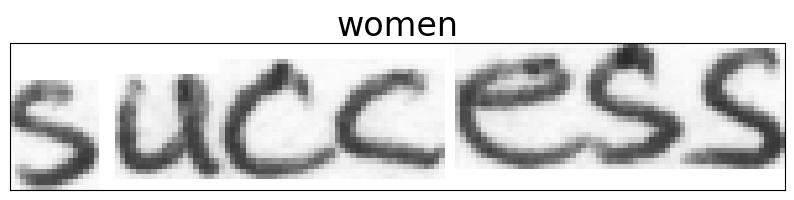

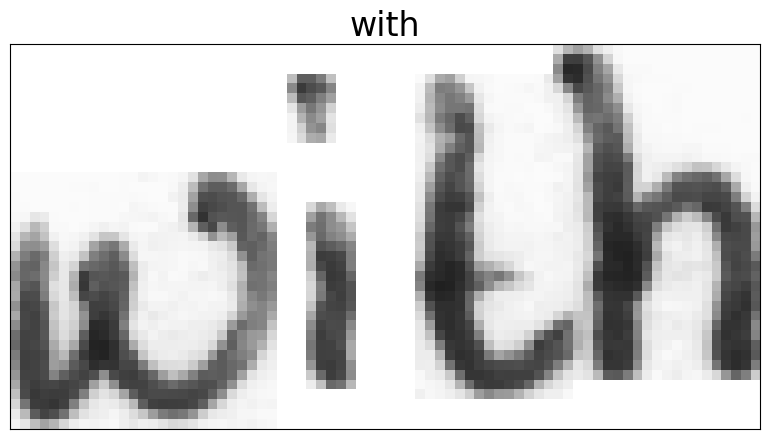

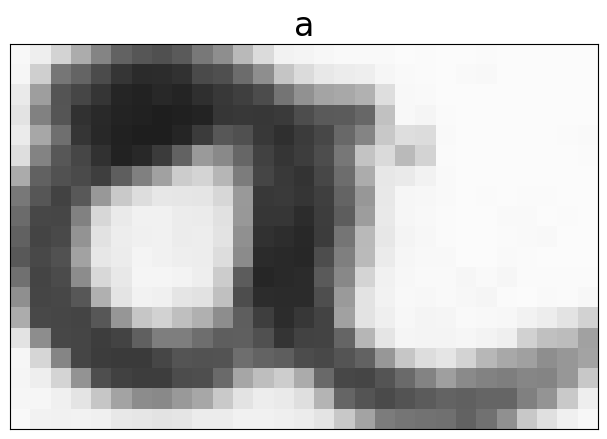

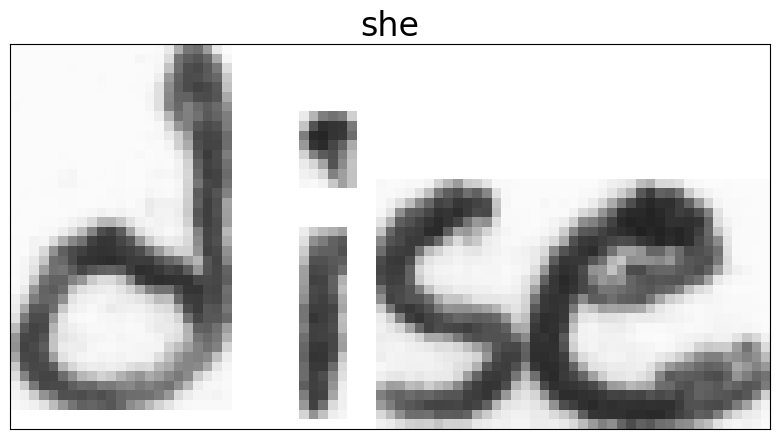

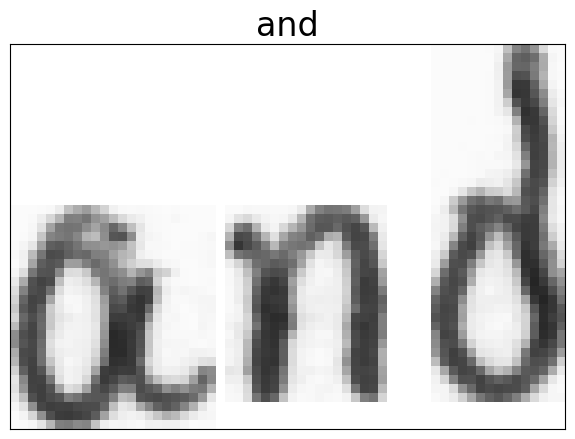

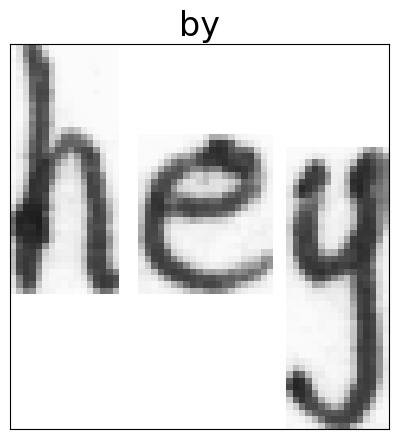

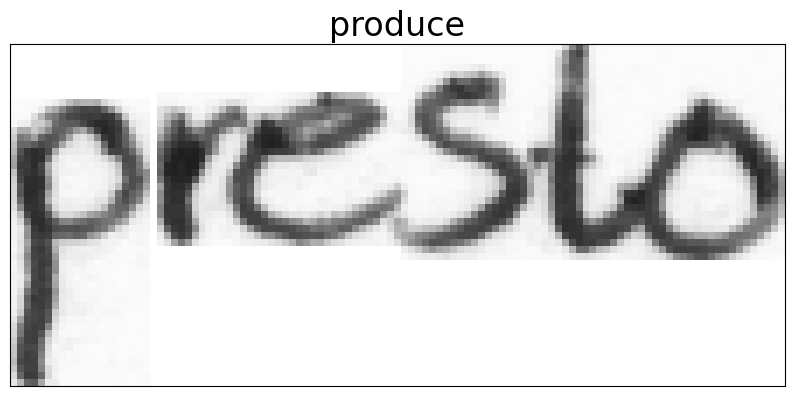

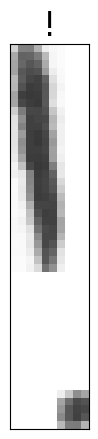

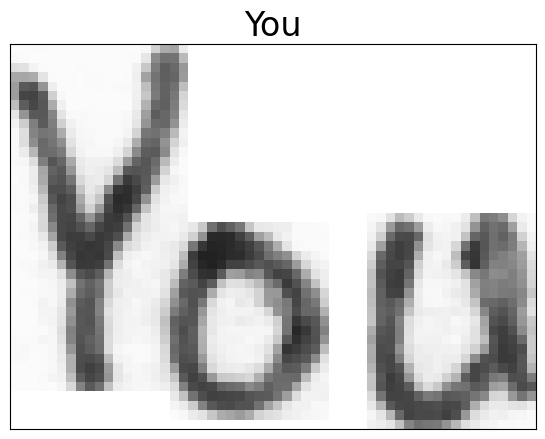

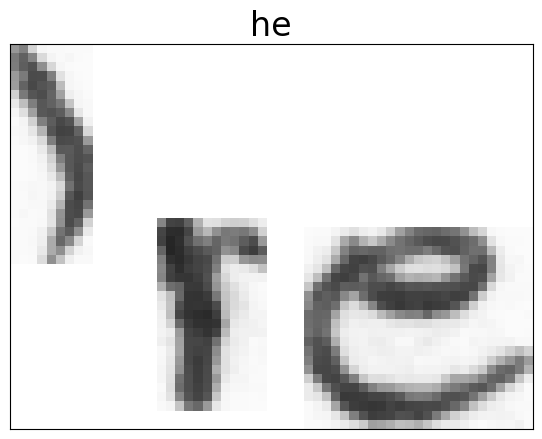

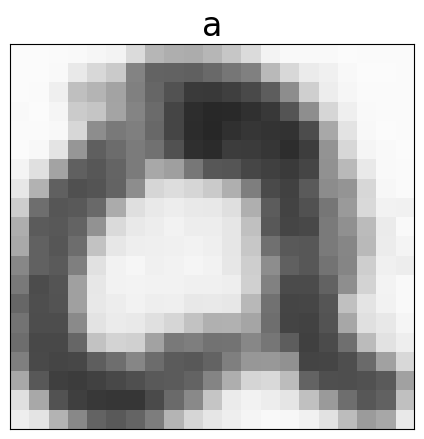

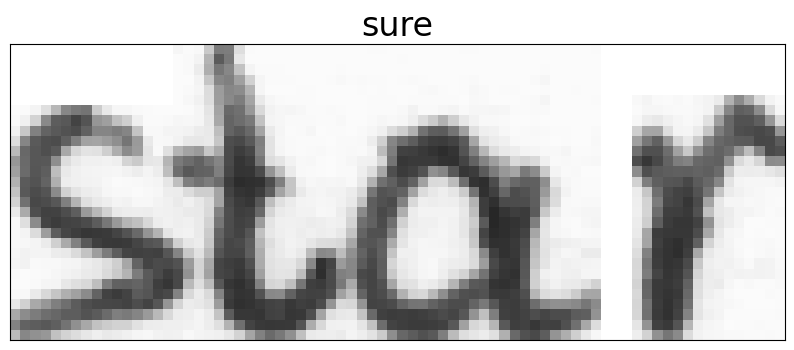

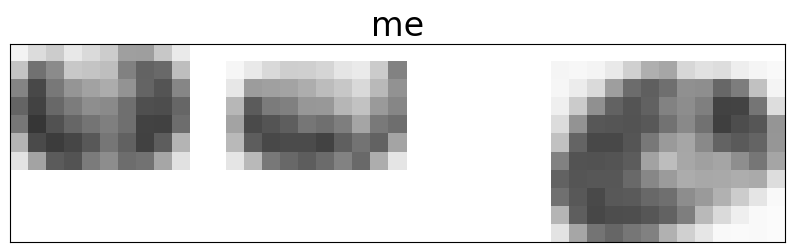

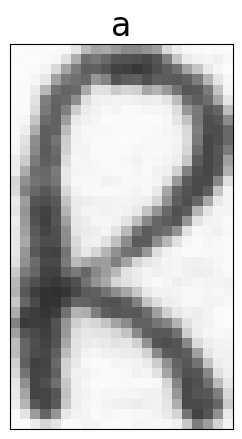

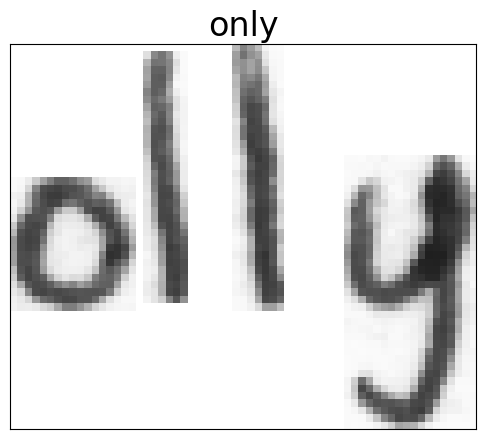

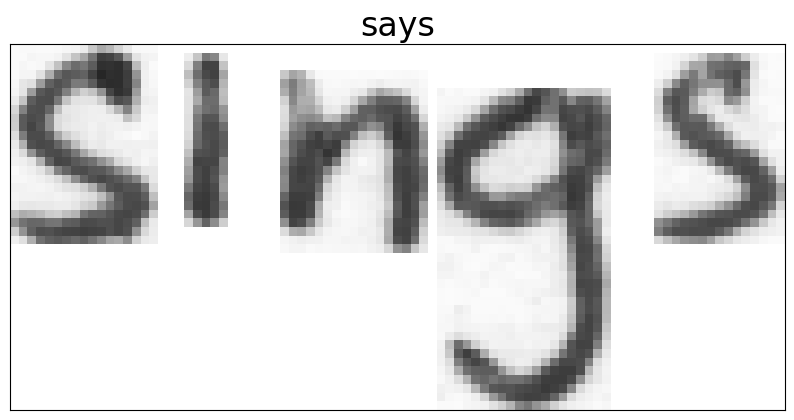

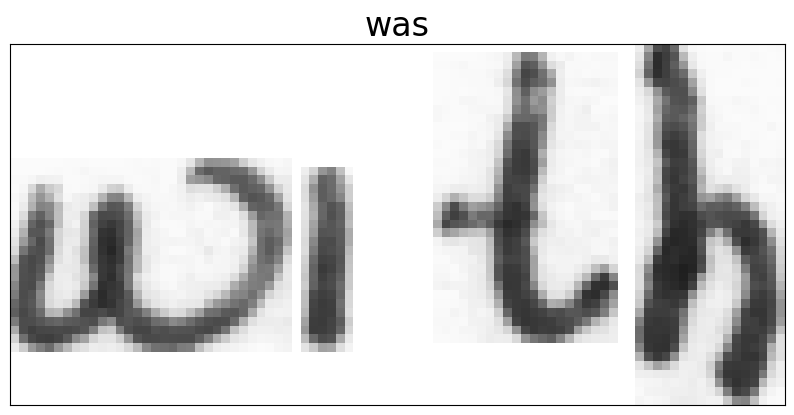

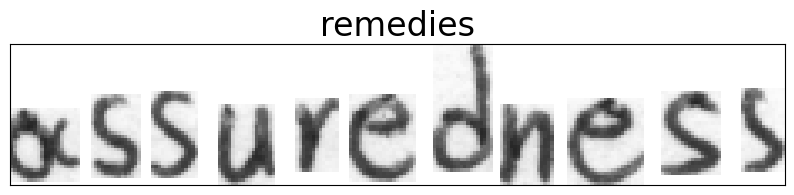

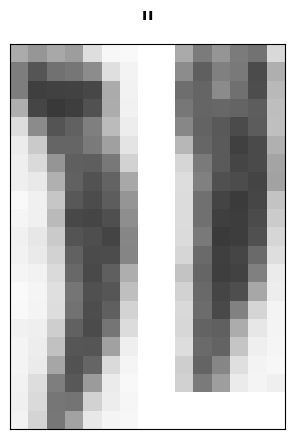

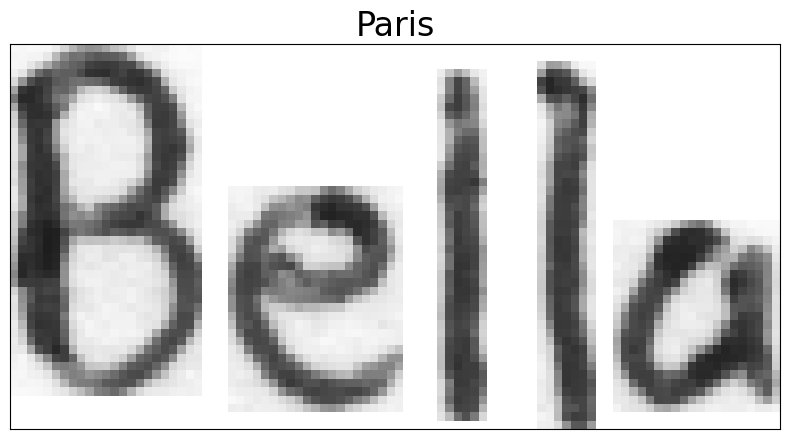

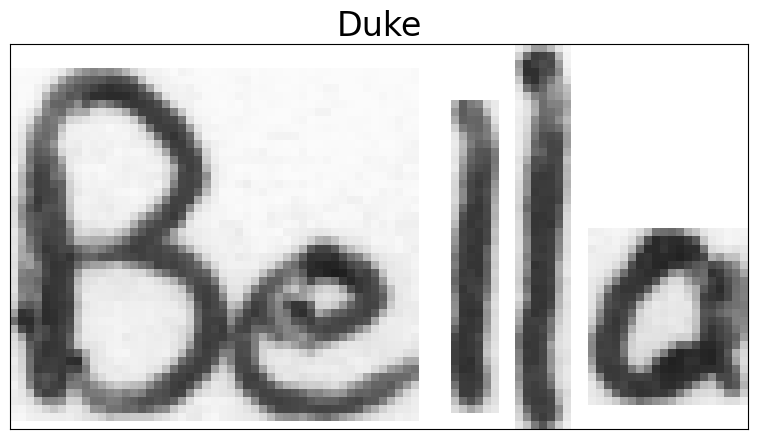

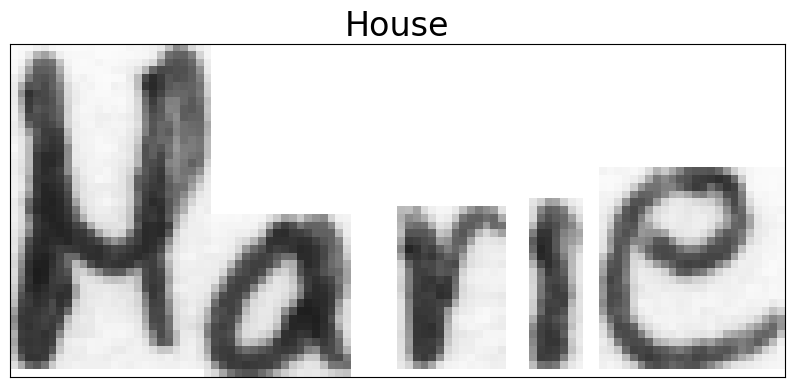

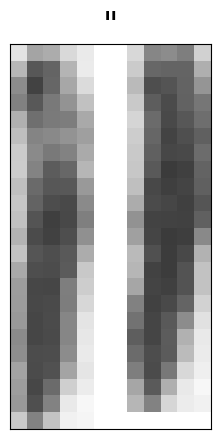

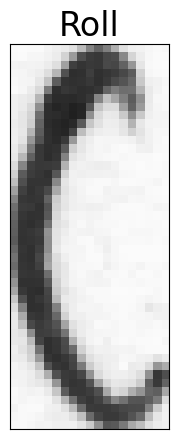

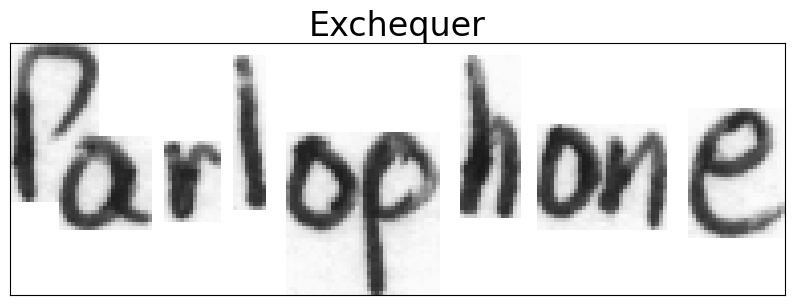

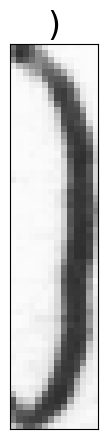

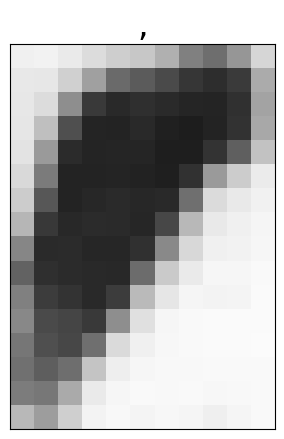

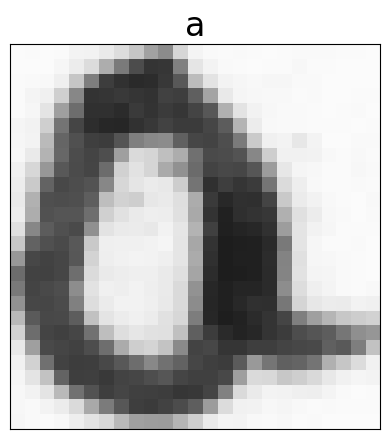

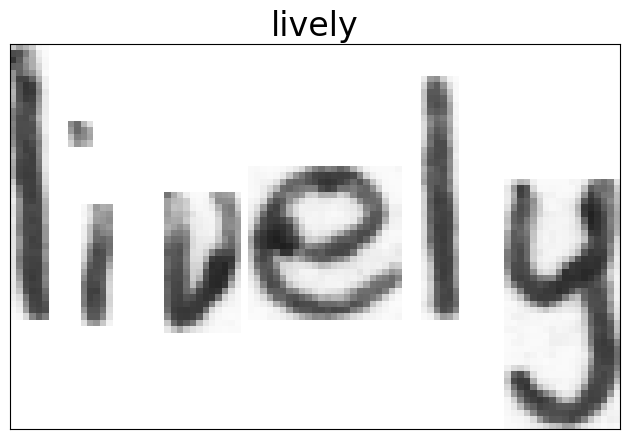

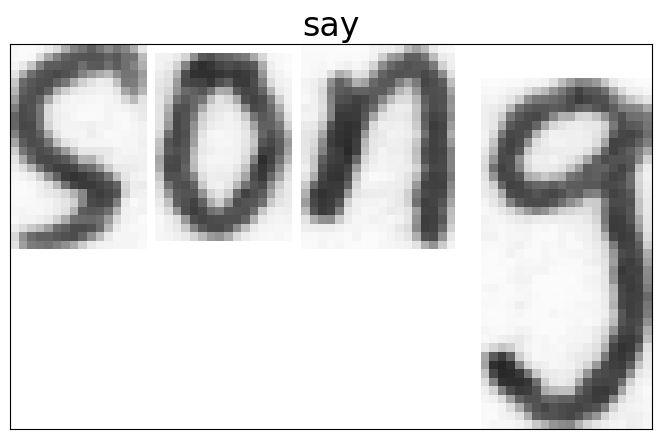

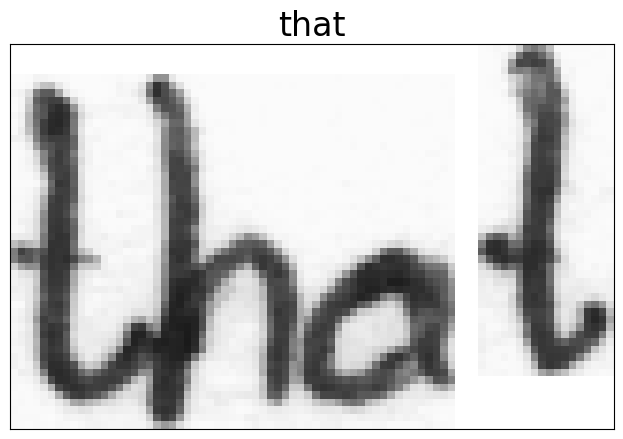

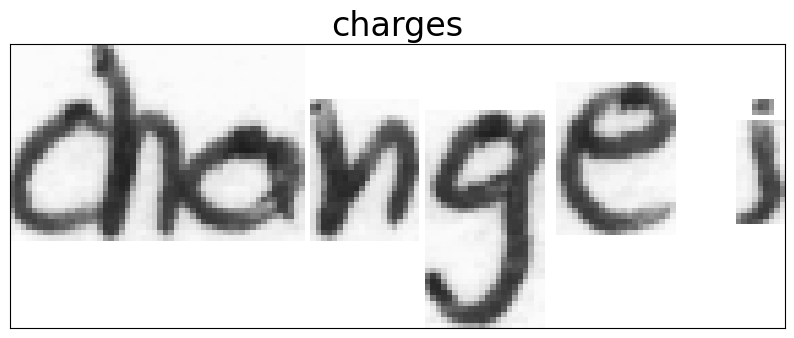

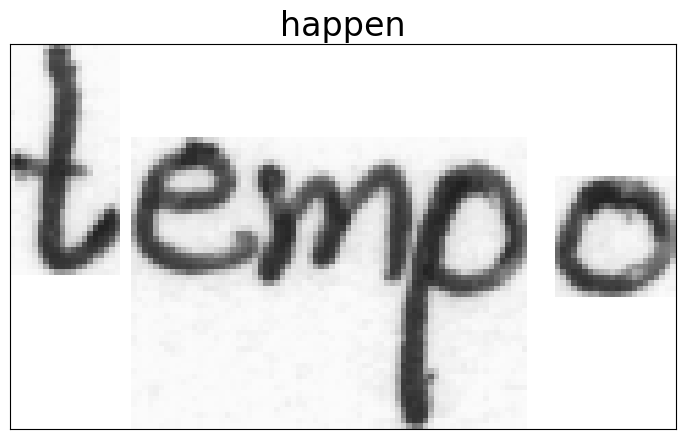

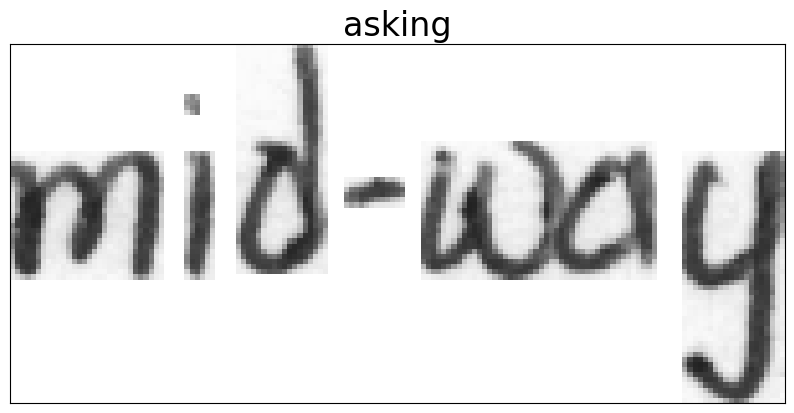

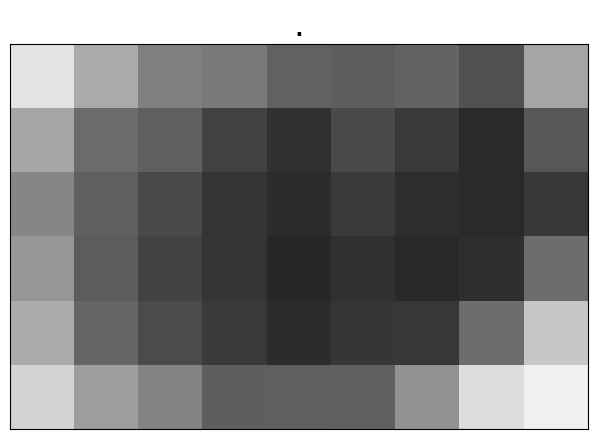

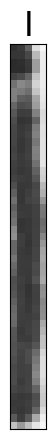

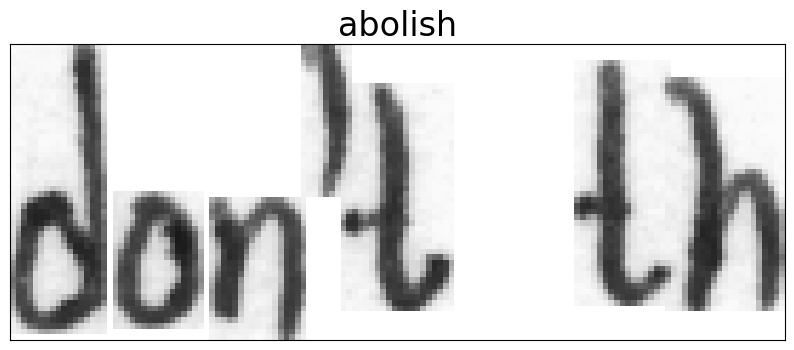

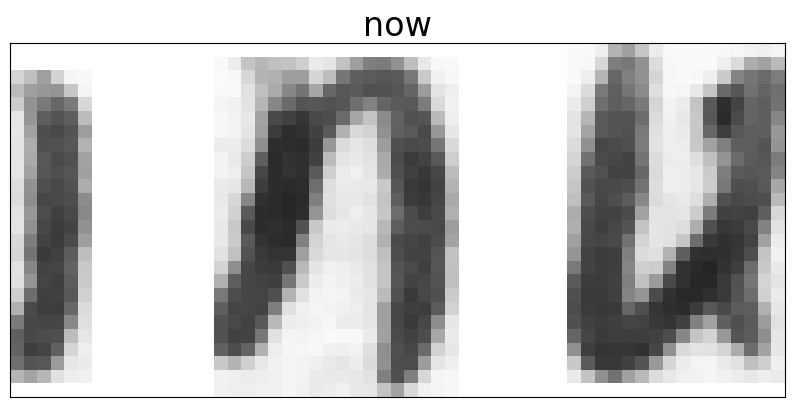

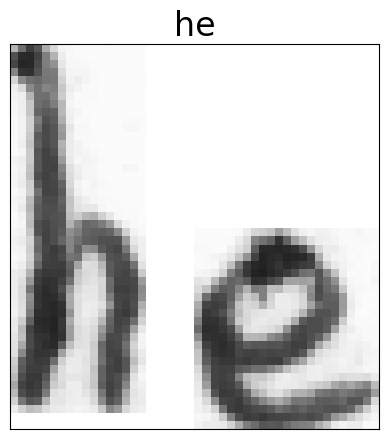

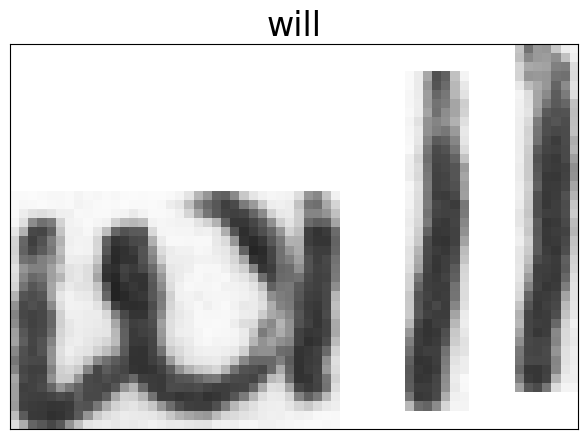

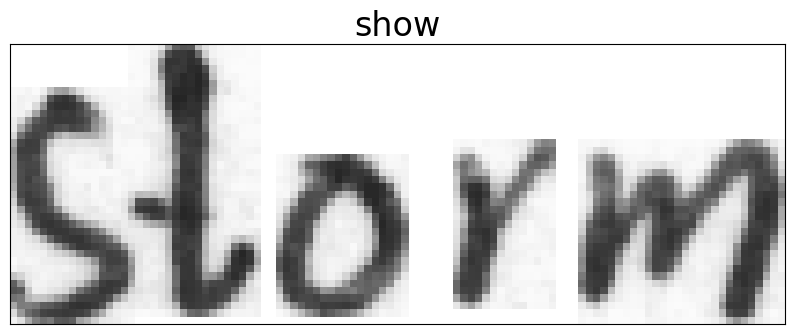

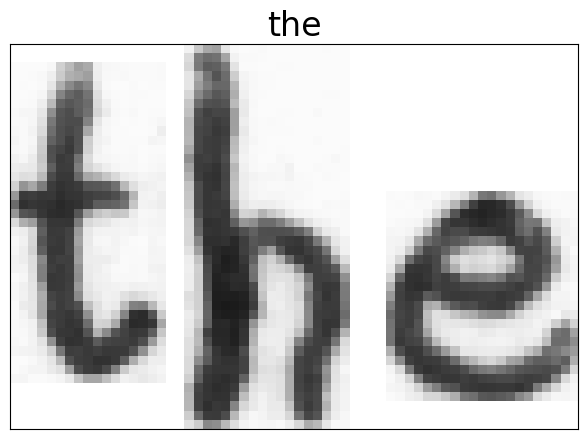

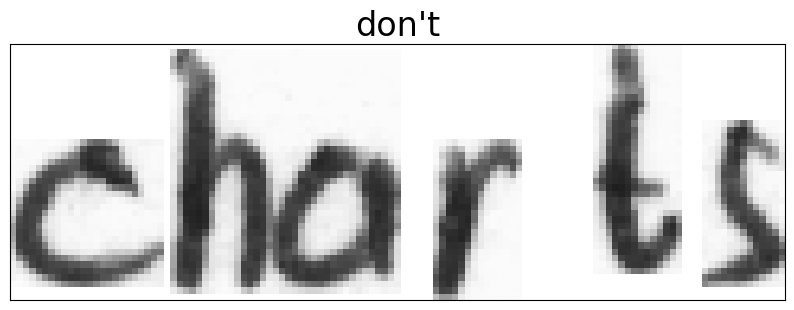

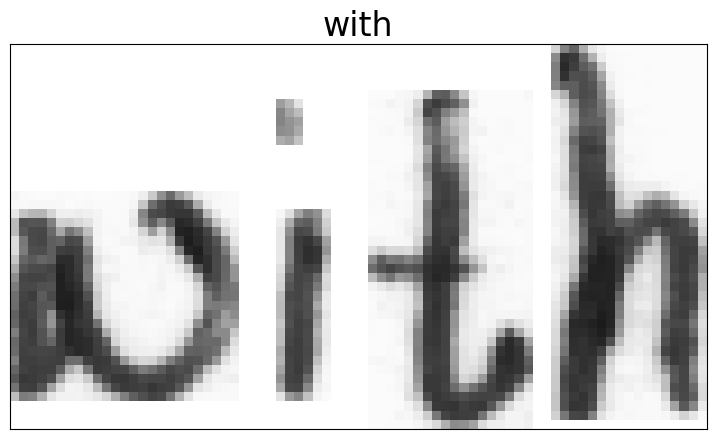

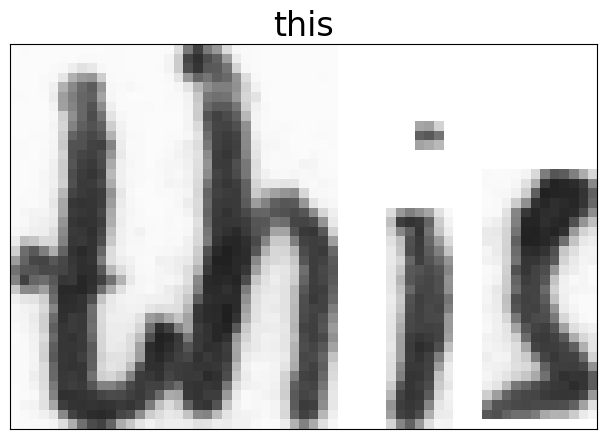

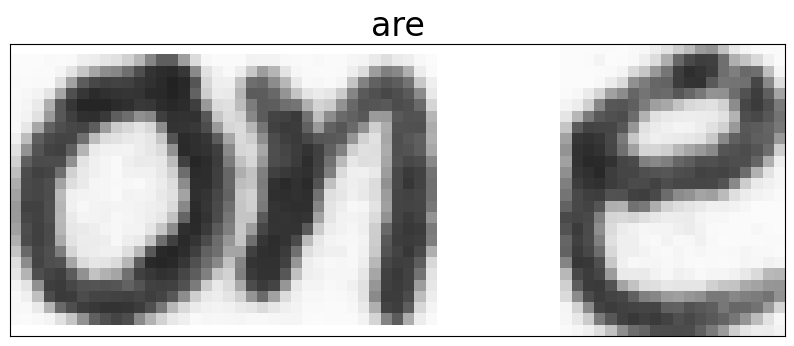

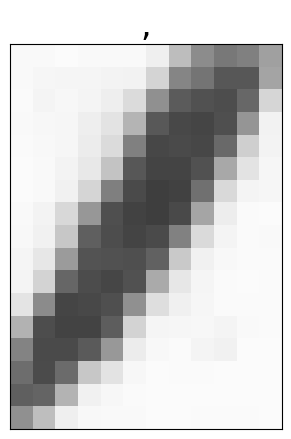

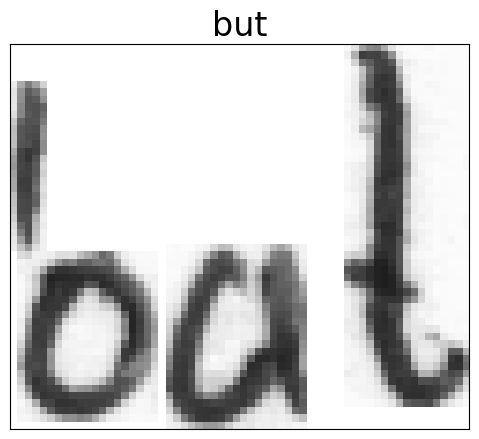

In [16]:
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

for test_word_record in test_word_records[:50]:
    image_file = test_word_record.file_path
    image = Image.open(image_file).convert('RGB')

    inputs = test_processor(
        images=image,
        texts=test_processor.tokeniser.bos_token,
        return_tensors='pt'
    )

    model_output = model.generate(
        inputs,
        test_processor,
        num_beams=4
    )

    predicted_text = test_processor.tokeniser.decode(model_output[0], skip_special_tokens=True)

    plt.figure(figsize=(10, 5))
    plt.title(predicted_text, fontsize=24)
    plt.imshow(np.array(image, dtype=np.uint8))
    plt.xticks([]), plt.yticks([])
    plt.show()